# 1) Setup

## 1a) Library functions

In [45]:
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from time import time
from datetime import datetime, timedelta
from copy import copy
import os
import random

#sklearn
from sklearn.model_selection import train_test_split
import sklearn as skl
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
from sklearn.inspection import permutation_importance

#Tensorflow
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import models
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, BatchNormalization
from tensorflow.keras import utils
from tensorflow.keras import optimizers
from tensorflow.keras import initializers
from keras import backend as K

#LTR tensorflow
from tensorflow.keras import layers, activations, losses, Model, Input
from tensorflow.nn import leaky_relu
from itertools import combinations
from tensorflow.keras.utils import plot_model, Progbar

#tensorflow rankings
import tensorflow_ranking as tfr

# Set random seed for reproducability
#tensorflow.random.set_seed(0)

print("done")

done


## 1b) Helper functions

In [46]:
def ListUnion(l1, l2):
    union = list(set(l1) | set(l2))
    return union

In [47]:
def regression_analysis(X,Y, ylabel = "Return for our strategy"):
    #remove nans
    #X = X[~np.isnan(Y)]
    #Y = Y[~np.isnan(Y)]
    #X = X[~np.isnan(X)]
    #Y = Y[~np.isnan(X)]
    res = pd.DataFrame(index = range(len(X)))
    res["X"] = X
    res["Y"] = Y
    res = res.dropna(how = "any")
    X = np.array(res["X"])
    Y = np.array(res["Y"])
    
    #fit OLS
    X2 = sm.add_constant(X)
    model = sm.OLS(Y, X2).fit() ## sm.OLS(output, input)
    coeff = [model.params[1],model.params[0]]
    
    #correlation
    corr = sp.stats.pearsonr(X,Y)
    
    #plot
    plt.scatter(X,Y,marker = ".");
    x_plot = np.arange(X.min(),X.max(),0.01)
    plt.plot(x_plot,np.polyval(coeff,x_plot),color = "orange");
    plt.xlabel("Return for index")
    plt.ylabel(ylabel)
    #title = "alpha = %.5f  |  beta = %.5f, \n pval_alpha = %.5f  |  correlation = %.5f" % (model.params[0],model.params[1],model.pvalues[0],corr[0])
    title = "alpha = %.5f  |  beta = %.5f  |  corr = %.5f" % (model.params[0],model.params[1],corr[0])
    plt.title(title)
    return;


In [48]:
def get_TrainTest(df_train,df_test,features, target, is_regression = True, is_ltr = False):
    """
    Get Train & Test matrices in correct format
    """
    x_train = df_train[features].values
    y_train = df_train[target].values
    x_test = df_test[features].values
    y_test = df_test[target].values

    #set data types
    x_train = x_train.astype('float32')
    x_test = x_test.astype('float32')
    y_train =y_train.astype('float32')
    y_test = y_test.astype('float32')

    #change data type if classification
    if is_regression == False:
        y_train = y_train > 0  #classification
        y_test = y_test > 0    #classification
        y_train = utils.to_categorical(y_train)
        y_test = utils.to_categorical(y_test)
    print ('Training Set: %d, Test Set: %d \n' % (len(x_train), len(x_test)))
    
    #provide queries if ltr
    if is_ltr:
        #queries
        q_train = df_train["month"].values
        q_test = df_test["month"].values
        #reformat output for ltr as rankings
        y_train = df_train.groupby("month")[target].rank("dense", ascending = False).values
        y_test = df_test.groupby("month")[target].rank("dense", ascending = False).values
        y_train =y_train.astype('int')
        y_test = y_test.astype('int')
        return x_train, y_train, q_train, x_test, y_test, q_test
    else:
        return x_train, y_train, x_test, y_test

In [49]:
def create_NN(hidden, dropout, input_dim, is_regression = True, std =  0.01, seed = 1):
    """
    Create MLP regression / classifier with random initialisation, Batch Normalisation & dropout
    """
    if len(hidden) != len(dropout):
        raise ValueError("Incompatible sequence lengths for hidden & dropout")
    model = Sequential()
    #input layer
    model.add(Dense(hidden[0], input_dim=input_dim, activation='relu',kernel_initializer=initializers.RandomNormal(stddev=std, seed = seed)))
    model.add(BatchNormalization())
    model.add(Dropout(0.5, seed = seed))
    #hidden layers
    for i in range(1,len(hidden)):
        model.add(Dense(hidden[i], input_dim=hidden[i-1], activation='relu',kernel_initializer=initializers.RandomNormal(stddev=std, seed = seed)))
        model.add(BatchNormalization())
        model.add(Dropout(dropout[i], seed = seed))
    #output layer
    if is_regression:
        model.add(Dense(1, input_dim=hidden[-1], activation=None,kernel_initializer=initializers.RandomNormal(stddev=std, seed = seed)))
    else:
        model.add(Dense(2, input_dim=hidden[-1], activation="softmax",kernel_initializer=initializers.RandomNormal(stddev=std, seed = seed)))
    return model
    

In [50]:
def train_NN(model, x_train, y_train, x_test, y_test, learning_rate = 0.1, is_regression = True, num_epochs = 50, plot_graph = False):
    """
    Train NN with Adam optimiser
    """
    #create optimiser
    opt = optimizers.Adam(learning_rate=learning_rate)
    if is_regression:
        loss_fn = keras.losses.MeanSquaredError()
    else:
        loss_fn = keras.losses.CategoricalCrossentropy()
    model.compile(loss=loss_fn,
                  optimizer=opt,
                  metrics=[loss_fn])
    #fit model
    history = model.fit(x_train, y_train, epochs=num_epochs, batch_size=500, validation_data=(x_test, y_test), verbose = 0)

    #plot fitting results
    if plot_graph:
        epoch_nums = range(1,num_epochs+1)
        training_loss = history.history["loss"]
        validation_loss = history.history["val_loss"]
        plt.plot(epoch_nums, training_loss)
        plt.plot(epoch_nums, validation_loss)
        plt.xlabel('epoch')
        plt.ylabel('loss')
        plt.legend(['training', 'validation'], loc='upper right')
        plt.show()
    
    return model, history

In [51]:
def get_Matrices(model, x_test, df_test, company_name = "TICKER", is_regression = True, pct = 0.1, is_short = False, max_ret = 10):
    """
    create return & weight matrices
    """
    # predict outputs
    model_output = model.predict(x_test)
    if is_regression == False:
        model_output = model_output[:,1]
    #map to original test dataframe for price data
    predictions = df_test.iloc[:,:5]
    predictions["pred"] = model_output
    
    #rank predictions
    predictions["rank"] = predictions.groupby("month")["pred"].rank("dense", ascending = False)
    rank_table = pd.pivot_table(predictions, values="rank", index=["month"],
                    columns=[company_name])
    
    #create weight matrix
    weight_matrix = pd.DataFrame(index = rank_table.index, columns = rank_table.columns, data = 0)
    weight_matrix[rank_table.lt(np.floor(pct*rank_table.max(axis = 1))+1, axis = 0)] = 1/np.transpose(np.tile(np.floor(rank_table.max(axis = 1)*pct),(len(rank_table.columns),1)))
    # include shorts
    if is_short:
        weight_matrix[rank_table.gt(np.floor((1-pct)*rank_table.max(axis = 1))+1, axis = 0)] = -1/np.transpose(np.tile(np.floor(rank_table.max(axis = 1)*pct),(len(rank_table.columns),1)))
    
    #create returns matrix
    returns_matrix = pd.pivot_table(predictions, values="pred_target", index=["month"],
                    columns=[company_name])
    
    #backfill if returns are suspiciously high
    returns_matrix[returns_matrix > max_ret] = returns_matrix.shift()
    return returns_matrix, weight_matrix, rank_table, model_output

In [52]:
def get_Matrices_LTR(model_output, df_test, company_name = "TICKER", pct = 0.1, is_short = False, max_ret = 10, discretise = True):
    """
    create return & weight matrices
    """
    #convert to rankings
    if discretise:
        predictions = np.sign(model_output-0.5)
    else:
        predictions = model_output
    n_outputs = len(predictions)
    df_pairs = pd.DataFrame(index = range(len(predictions)))
    df_pairs[str(df_test.columns[0])] = list(df_test.iloc[pair_test[:n_outputs,0],0])
    df_pairs["month"] = query_test[:n_outputs]
    df_pairs["pred"] = predictions[:n_outputs]
    df_pairs["first"] = pair_test[:n_outputs,0]
    df_pairs["second"] = pair_test[:n_outputs,1]
    df_ranks = df_pairs.groupby(["month",df_train.columns[0]])["pred"].sum().to_frame().reset_index()
    df_ranks["rank"] = df_ranks.groupby("month")["pred"].rank("dense", ascending = False)
    df_ranks = df_ranks.merge(df_test[[company_name,"month","pred_target"]],on  =[company_name,"month"], how = "left")
    rank_table = pd.pivot_table(df_ranks, values="rank", index=["month"],
                    columns=[company_name])
    
    #create weight matrix
    weight_matrix = pd.DataFrame(index = rank_table.index, columns = rank_table.columns, data = 0)
    weight_matrix[rank_table.lt(np.floor(pct*rank_table.max(axis = 1))+1, axis = 0)] = 1/np.transpose(np.tile(np.floor(rank_table.max(axis = 1)*pct),(len(rank_table.columns),1)))
    # include shorts
    if is_short:
        weight_matrix[rank_table.gt(np.floor((1-pct)*rank_table.max(axis = 1))+1, axis = 0)] = -1/np.transpose(np.tile(np.floor(rank_table.max(axis = 1)*pct),(len(rank_table.columns),1)))
    
    #create returns matrix
    returns_matrix = pd.pivot_table(df_ranks, values="pred_target", index=["month"],
                    columns=[company_name])
    
    #backfill if returns are suspiciously high
    returns_matrix[returns_matrix > max_ret] = returns_matrix.shift()
    return returns_matrix, weight_matrix, rank_table, model_output

In [53]:
def turnover_cost(w, k):
    """
    Calculate transaction costs. k is in bps, w is a weight matrix
    """
    k = k/10000  #convert to bps
    w.fillna(value = 0, inplace=True)
    return w.diff(1).abs().sum(axis = 1) * k

In [54]:
def calc_returns(returns_matrix, weight_matrix, k = 3):
    """
    Calculate returns & cumulative returns, including transaction costs of k bps.
    """
    #equal weighted
    if isinstance(weight_matrix,str):
        if weight_matrix == "equal":
            rets = returns_matrix.mean(axis = 1)
            rets.index = rets.index.to_timestamp()   #convert periods to timestamps
            cumrets = (1+rets).cumprod()
        else:
            raise ValueError("Invalid string argument. Must be equal")
    else:
        #calculate returns using weight matrix
        rets = (weight_matrix*returns_matrix.fillna(0)).sum(axis = 1)
        rets = rets - turnover_cost(weight_matrix, k)
        rets.index = rets.index.to_timestamp()   #convert periods to timestamps
        #calculate cumulative returns
        cumrets = (1+rets).cumprod()
    return rets, cumrets

In [55]:
def calc_sharpe(rets):
    #rets = monthly returns
    n = len(rets)/12   #no. of years
    cumrets = (1+rets).cumprod()   #cumulative returns
    #scale to average annual return and volatility
    sharpe = (cumrets[-1]**(1/n) - 1)/(np.std(rets) * np.sqrt(12))
    return sharpe

In [56]:
def calc_mdd(returns, verbose = False):
    #maximum drawdown
    cum_rets = (1 + returns).cumprod()
    max_cumret = cum_rets.cummax()  #max previous cumret
    dd = 1 - cum_rets/max_cumret   #all drawdowns
    
    #visual check
    if verbose:
        print(cum_rets[np.argmax(dd)-2:np.argmax(dd)+2])
        print(max_cumret[np.argmax(dd)-2:np.argmax(dd)+2])
        
    #ret
    return np.max(dd), np.argmax(dd)

In [57]:
def feature_importance(model, x_test, y_test, features, n_repeats=5, random_state=1, is_regression = True):
    if is_regression:
        scoring =  "neg_mean_squared_error"
    else:
        #neg_log_loss is technically correct, but not worth rewriting permutation importance to replace predict_proba with predict
        #scoring = "neg_log_loss"
        scoring =  "neg_mean_squared_error"
    result = permutation_importance(model, x_test, y_test, n_repeats=n_repeats, random_state=random_state, scoring = scoring)
    sorted_idx = result.importances_mean.argsort()
    labels = np.array(features)

    plt.boxplot(
        result.importances[sorted_idx].T, vert=False, labels=labels[sorted_idx]
    )
    plt.title("Permutation Importances (test set)")

    plt.tight_layout()
    plt.xticks(rotation = 45)
    plt.show()
    
    features_pi = list(labels[result.importances_mean > 0])
    print("Permutation importance > 0:")
    print(features_pi)
    return result, features_pi

In [58]:
def create_pairs(query, doc_features, doc_scores):
    # put data into pairs
    xi = []  #input 1
    xj = []  #input 2
    pij = []      #target
    pair_id = []    #pair
    pair_query_id = []    #pair_query

    for q in np.unique(query):
        query_idx = np.where(query == q)[0]
        for pair_idx in combinations(query_idx, 2):

            pair_id.append(pair_idx)
            i = pair_idx[0]
            j = pair_idx[1]
            xi.append(doc_features[i])
            xj.append(doc_features[j])
            pair_query_id.append(q)

            if doc_scores[i] == doc_scores[j]:
                _pij = 0.5
            elif doc_scores[i] > doc_scores[j]:
                _pij = 1
            else: 
                _pij = 0
            pij.append(_pij)

    xi = np.array(xi)
    xj = np.array(xj)
    pij = np.array(pij)
    pair_query_id = np.array(pair_query_id)
    
    return xi, xj, pij, pair_id, pair_query_id

## 1c) Read data

In [59]:
#df_nn = pd.read_pickle("df_NeuralNetworkFeatures_fillna.pkl")
#df_nn = pd.read_pickle("df_NeuralNetworkFeatures_bloomberg.pkl")
df_nn = pd.read_pickle("df_NeuralNetworkFeatures.pkl")
df_nn

,TICKER,month,pred_target,mcap,gsector,debt_assets,de_ratio,evm,pe_exi,roe,...,MEDPTG,PCTUP4W,PCTDOWN4W,volume,gsector,return_1M,return_3M,return_6M,return_9M,return_12M
212,SUNW,2007-02,-0.166667,1.917384e+07,2.0,0.551,1.225,25.053,-188.620,-0.069,...,2.658267,0.769231,0.000000,1.462797,2.0,0.043478,6.999992e-08,-5.278261e-07,-0.314286,-0.478261
213,SUNW,2007-03,-0.200000,1.597820e+07,2.0,0.551,1.225,25.053,-184.920,-0.069,...,2.668177,0.000000,0.000000,0.584903,2.0,-0.166667,-2.000005e-01,-1.304353e-01,-0.428572,-0.473685
214,SUNW,2007-04,-0.312500,1.292800e+07,2.0,0.551,1.225,25.053,-160.620,-0.069,...,2.678123,0.000000,0.000000,-0.298131,2.0,-0.200000,-3.043483e-01,-3.333336e-01,-0.428572,-0.597990
215,SUNW,2007-05,0.090909,8.934090e+06,2.0,0.547,1.208,21.879,-408.010,-0.024,...,2.692627,0.111111,0.444444,0.482997,2.0,-0.312500,-5.416669e-01,-5.416668e-01,-0.541667,-0.685715
216,SUNW,2007-06,0.666667,9.746280e+06,2.0,0.547,1.208,21.879,-420.800,-0.024,...,2.690307,0.000000,0.000000,-0.234375,2.0,0.090909,-4.000001e-01,-5.200004e-01,-0.478261,-0.657143
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
156571,CBOE,2020-07,0.051425,9.622444e+09,6.0,0.351,0.541,14.910,22.430,0.117,...,1.140747,0.000000,0.500000,-0.163128,6.0,-0.059820,-1.145444e-01,-2.836029e-01,-0.231075,-0.187547
156572,CBOE,2020-08,-0.044122,9.982897e+09,6.0,0.360,0.561,14.185,22.065,0.124,...,1.055180,0.000000,0.500000,0.071894,6.0,0.051425,-1.338531e-01,-1.884053e-01,-0.219395,-0.218739
156573,CBOE,2020-09,-0.073513,9.542427e+09,6.0,0.360,0.561,14.185,21.091,0.124,...,1.079417,0.133333,0.066667,0.091796,6.0,-0.044122,-5.508711e-02,-9.080990e-03,-0.260677,-0.225590
156574,CBOE,2020-10,0.128552,8.782734e+09,6.0,0.360,0.561,14.185,19.541,0.124,...,1.144780,0.062500,0.375000,0.130047,6.0,-0.073513,-6.884904e-02,-1.755072e-01,-0.332926,-0.284015


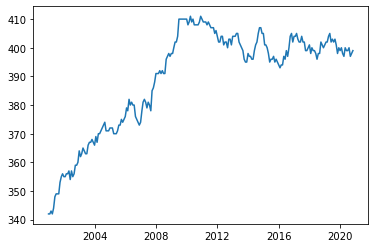

In [60]:
plt.plot(sorted(df_nn["month"].unique().to_timestamp()),df_nn.groupby("month").apply(len))

In [61]:
#np.isinf(df_nn.iloc[:,2:]).sum()

In [62]:
df_nn[df_nn["TICKER"] == "MSFT"]

,TICKER,month,pred_target,mcap,gsector,debt_assets,de_ratio,evm,pe_exi,roe,...,MEDPTG,PCTUP4W,PCTDOWN4W,volume,gsector,return_1M,return_3M,return_6M,return_9M,return_12M
540,MSFT,2001-01,-0.033777,3.256059e+11,7.0,0.211,0.268,39.193,17.249,0.267,...,1.184378,0.000000,0.00000,-0.118934,7.0,0.407781,-0.113430,-0.125336,-0.124553,-0.376118
541,MSFT,2001-02,-0.073093,3.147881e+11,7.0,0.202,0.254,31.078,16.389,0.245,...,1.237797,0.142857,0.00000,-0.227864,7.0,-0.033777,0.028322,-0.154880,-0.056944,-0.339861
542,MSFT,2001-03,0.238857,2.917792e+11,7.0,0.202,0.254,31.078,15.191,0.245,...,1.311057,0.000000,0.00000,0.229647,7.0,-0.073093,0.260807,-0.093264,-0.316407,-0.485294
543,MSFT,2001-04,0.021107,3.629801e+11,7.0,0.202,0.254,31.078,18.819,0.245,...,1.101493,0.000000,0.00000,0.097185,7.0,0.238857,0.109519,-0.016334,-0.029544,-0.028675
544,MSFT,2001-05,0.055218,3.723338e+11,7.0,0.196,0.245,24.730,19.110,0.227,...,1.144823,0.062500,0.00000,-0.145066,7.0,0.021107,0.172543,0.205751,-0.009060,0.105773
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
774,MSFT,2020-07,0.102580,1.552131e+12,7.0,0.618,1.618,18.800,34.111,0.445,...,1.047562,0.406250,0.03125,0.006100,7.0,0.007371,0.147149,0.211464,0.443275,0.523540
775,MSFT,2020-08,-0.067397,1.706733e+12,7.0,0.607,1.547,24.868,39.155,0.401,...,1.019625,0.064516,0.00000,-0.100921,7.0,0.102580,0.233506,0.399104,0.502063,0.654928
776,MSFT,2020-09,-0.037370,1.591704e+12,7.0,0.607,1.547,24.868,36.516,0.401,...,1.097906,0.096774,0.00000,0.110498,7.0,-0.067397,0.035849,0.340385,0.344689,0.530403
777,MSFT,2020-10,0.060058,1.530774e+12,7.0,0.607,1.547,24.868,35.151,0.401,...,1.148464,0.137931,0.00000,-0.179347,7.0,-0.037370,-0.010157,0.135497,0.199159,0.428616


In [63]:

(1+ df_nn[df_nn["TICKER"] == "MSFT"]["pred_target"]).cumprod()

540     0.966223
541     0.895599
542     1.109519
543     1.132938
544     1.195496
         ...    
774    11.579957
775    10.799502
776    10.395925
777    11.020283
778    11.450140
Name: pred_target, Length: 239, dtype: float64

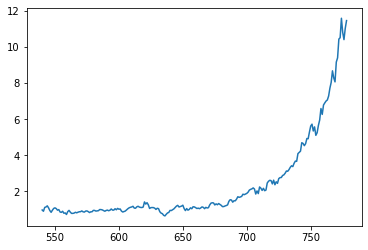

In [64]:
plt.plot((1+ df_nn[df_nn["TICKER"] == "MSFT"]["pred_target"]).cumprod())

## 1d) Separate data into 5-year "chunks"

In [65]:
#set seed
seed = 1
os.environ['PYTHONHASHSEED']=str(seed)
random.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
#Configure a new global `tensorflow` session
#session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
#sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=session_conf)
#tf.compat.v1.keras.backend.set_session(sess)

#portfolio params
k = 3                #transaction costs in bps
pct = 0.1           # proportion of the portfolio long
is_short = False     #whether to use long-short portfolio

print("done")

done


In [66]:
df_train = df_nn[(df_nn["month"]>= "2001-01") & (df_nn["month"]<= "2005-12")].reset_index(drop = True)
df_test = df_nn[(df_nn["month"]>= "2006-01") & (df_nn["month"]<= "2020-12")].reset_index(drop = True)
print("done")

done


# 2) MLP Classification

In [23]:
#model params
hidden = [300,300,150,150,50]
dropout = [0.5,0.5,0.3,0.3,0.1]
is_regression = False
learning_rate = 0.01
num_epochs = 10

## 2a) All features

Training Set: 21742, Test Set: 71315 



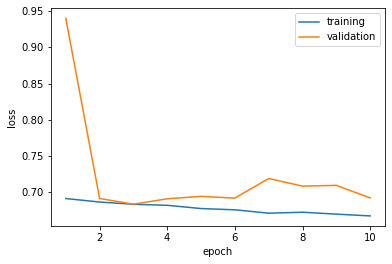

In [70]:
#model params defined in 1d
#reset seed
tf.random.set_seed(seed)

#split data
features = ["debt_assets", "de_ratio", "evm", "pe_exi",
               "roe", "npm","ps", "ptb", "pcf", "aftret_invcapx",
              "CPI", "PMI", "PPI", "FedFundsTargetRate", "GDP", 
              "MedianHomeSalesPrice", "PrivateHousingStarts","NonFarmPayrolls", "Unemployment",
            "MEDPTG", "PCTUP4W", "PCTDOWN4W", "volume",
             "return_1M", "return_3M", "return_6M", "return_9M", "return_12M"]
target = "pred_target"
x_train, y_train, x_test, y_test = get_TrainTest(df_train,df_test,features, target, is_regression = is_regression)

#create model & train
model = create_NN(hidden, dropout, input_dim = len(features), is_regression = is_regression, std = 0.01, seed = seed)
#print(model.summary())
model, history = train_NN(model, x_train, y_train, x_test, y_test, learning_rate = learning_rate, is_regression = is_regression, num_epochs = num_epochs, plot_graph = True)

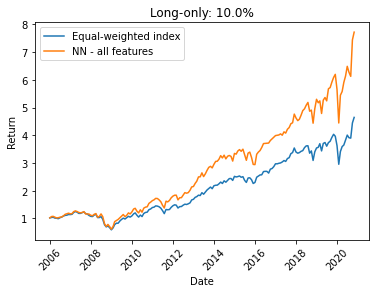

In [71]:
#calculate cost-adjusted returns & plot
#portfolio params defined in 1d

returns_matrix, weight_matrix, rank_table, model_output = get_Matrices(model, x_test, df_test,is_regression = is_regression, pct = pct, is_short = is_short, company_name = df_train.columns[0])
rets, cumrets = calc_returns(returns_matrix, weight_matrix = weight_matrix, k = k)

#calculate return & weight matrix for base strat - i.e. long 100%
returns_matrix_equal, weight_matrix_equal, rank_table_equal, model_output = get_Matrices(model, x_test, df_test,is_regression = is_regression, pct = 1, is_short = False, company_name = df_train.columns[0])
rets_equal, cumrets_equal = calc_returns(returns_matrix_equal, weight_matrix = weight_matrix_equal, k = k)

plt.plot(cumrets_equal.index, cumrets_equal, label = "Equal-weighted index")
plt.plot(cumrets.index, cumrets, label = "NN - all features")
plt.legend();
plt.xlabel("Date");
plt.xticks(rotation = 45);
plt.ylabel("Return")
plt.title("Long-only: " + str(pct*100) + "%");

In [72]:
#save rankings
model_output = model.predict(x_test)
if is_regression == False:
    model_output = model_output[:,1]
#map to original test dataframe for price data
predictions = df_test.iloc[:,:5]
predictions["pred"] = model_output

#rank predictions
predictions["rank"] = predictions.groupby("month")["pred"].rank("dense", ascending = False)
pred_table = pd.pivot_table(predictions, values="pred", index=["month"],
                columns=[df_test.columns[0]])
rank_table = pd.pivot_table(predictions, values="rank", index=["month"],
                columns=[df_test.columns[0]])

rank_table.to_csv("Rankings/NN_Classification_ranks.csv")
pred_table.to_csv("Rankings/NN_Classification_modeloutputs.csv")

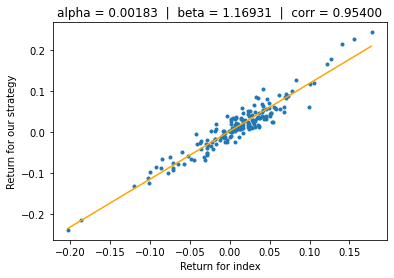

In [26]:
regression_analysis(np.array(rets_equal),np.array(rets))

In [27]:
#sharpe ratio
sharpe = calc_sharpe(rets)
print("NN sharpe: ", sharpe)
mdd = calc_mdd(rets)
print("NN mdd: ", mdd[0])

sharpe_equal = calc_sharpe(rets_equal)
print("Base index sharpe: ", sharpe_equal)
mdd_equal = calc_mdd(rets_equal)
print("Base index mdd: ", mdd_equal[0])

NN sharpe:  0.6764465416111847
NN mdd:  0.5207922808785568
Base index sharpe:  0.6120306030872815
Base index mdd:  0.5304379670749022


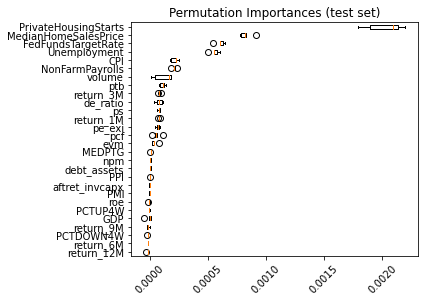

Permutation importance > 0:
['debt_assets', 'de_ratio', 'evm', 'pe_exi', 'npm', 'ps', 'ptb', 'pcf', 'aftret_invcapx', 'CPI', 'PPI', 'FedFundsTargetRate', 'MedianHomeSalesPrice', 'PrivateHousingStarts', 'NonFarmPayrolls', 'Unemployment', 'MEDPTG', 'volume', 'return_1M', 'return_3M']


In [30]:
#permutation importance
importance,features_pi = feature_importance(model, x_test, y_test, features, n_repeats=5, random_state=seed, is_regression = is_regression)

In [31]:
# save model
if is_regression == True:
    label = "Models/NNreg_" + str(len(features)) + "features_" + str(len(hidden)) + "layers_" + str(num_epochs) + "epochs.h5"
else:
    label = "Models/NNclf_" + str(len(features)) + "features_" + str(len(hidden)) + "layers_" + str(num_epochs) + "epochs.h5"

model.save(label)
print("Model saved to: " + label)
#loaded_model = tf.keras.models.load_model(label, compile = False)

Model saved to: Models/NNclf_28features_5layers_10epochs.h5


In [32]:
#load model
if is_regression == True:
    label = "Models/NNreg_" + str(len(features)) + "features_" + str(len(hidden)) + "layers_" + str(num_epochs) + "epochs.h5"
else:
    label = "Models/NNclf_" + str(len(features)) + "features_" + str(len(hidden)) + "layers_" + str(num_epochs) + "epochs.h5"

loaded_model = tf.keras.models.load_model(label, compile = False)

## 2b) Returns-only features

Training Set: 21742, Test Set: 71315 



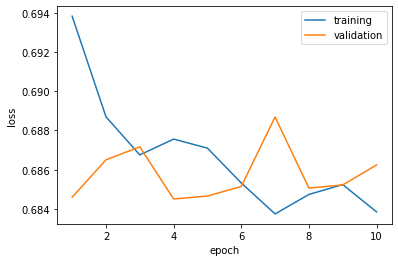

In [33]:
#model params defined in 1d
#reset seed
tf.random.set_seed(seed)

#split data
features = ["return_1M", "return_3M", "return_6M", "return_9M", "return_12M"]
target = "pred_target"
x_train, y_train, x_test, y_test = get_TrainTest(df_train,df_test,features, target, is_regression = is_regression)

#create model & train
model = create_NN(hidden, dropout, input_dim = len(features), is_regression = is_regression, std = 0.01, seed = seed)
#print(model.summary())
model, history = train_NN(model, x_train, y_train, x_test, y_test, learning_rate = learning_rate, is_regression = is_regression, num_epochs = num_epochs, plot_graph = True)

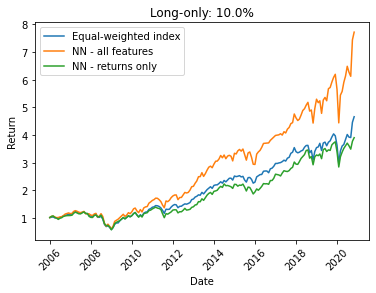

In [34]:
#calculate cost-adjusted returns & plot
#portfolio params defined in 1d
returns_matrix, weight_matrix, rank_table, model_output = get_Matrices(model, x_test, df_test, is_regression = is_regression, pct = pct, is_short = is_short, company_name = df_train.columns[0])
rets_retonly, cumrets_retonly = calc_returns(returns_matrix, weight_matrix = weight_matrix, k = k)

#calculate return & weight matrix for base strat - i.e. long 100%
returns_matrix_equal, weight_matrix_equal, rank_table_equal, model_output = get_Matrices(model, x_test, df_test,is_regression = is_regression, pct = 1, is_short = False, company_name = df_train.columns[0])
rets_equal, cumrets_equal = calc_returns(returns_matrix_equal, weight_matrix = weight_matrix_equal, k = k)

plt.plot(cumrets_equal.index, cumrets_equal, label = "Equal-weighted index")
plt.plot(cumrets.index, cumrets, label = "NN - all features")
plt.plot(cumrets_retonly.index, cumrets_retonly, label = "NN - returns only")
plt.legend();
plt.xlabel("Date");
plt.xticks(rotation = 45);
plt.ylabel("Return")
plt.title("Long-only: " + str(pct*100) + "%");

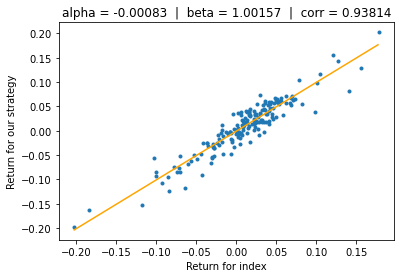

In [35]:
regression_analysis(np.array(rets_equal),np.array(rets_retonly))

In [36]:
#sharpe ratio
print("NN sharpe, all features: ", sharpe)

sharpe_retonly = calc_sharpe(rets_retonly)
print("NN sharpe, returns only: ", sharpe_retonly)
print("Base index sharpe: ", sharpe_equal)

NN sharpe, all features:  0.6764465416111847
NN sharpe, returns only:  0.5061514755807156
Base index sharpe:  0.6120306030872815


In [37]:
#permutation importance
#importance = feature_importance(model, x_test, y_test, features, n_repeats=5, random_state=seed, is_regression = is_regression)

In [38]:
# save model
if is_regression == True:
    label = "Models/NNreg_" + str(len(features)) + "features_" + str(len(hidden)) + "layers_" + str(num_epochs) + "epochs.h5"
else:
    label = "Models/NNclf_" + str(len(features)) + "features_" + str(len(hidden)) + "layers_" + str(num_epochs) + "epochs.h5"

model.save(label)
print("Model saved to: " + label)
#loaded_model = tf.keras.models.load_model(label, compile = False)

Model saved to: Models/NNclf_5features_5layers_10epochs.h5


## 2c) Permutation Importance Features
- Only those with PI above 0
- and return features!

['aftret_invcapx', 'FedFundsTargetRate', 'PrivateHousingStarts', 'return_9M', 'volume', 'PPI', 'return_12M', 'de_ratio', 'npm', 'pcf', 'ptb', 'NonFarmPayrolls', 'return_3M', 'Unemployment', 'MedianHomeSalesPrice', 'pe_exi', 'evm', 'return_1M', 'CPI', 'PCTDOWN4W', 'ps', 'MEDPTG', 'debt_assets']
Training Set: 21742, Test Set: 71315 



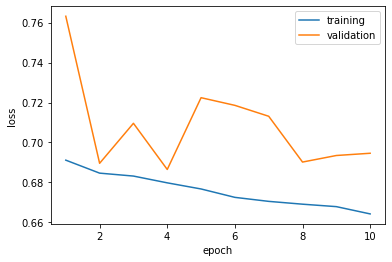

In [39]:
#model params defined in 1d
#reset seed
tf.random.set_seed(seed)

#split data
features = ['npm', 'aftret_invcapx', 'PMI', 'FedFundsTargetRate', 'GDP', 
            'PrivateHousingStarts', 'NonFarmPayrolls', 'Unemployment', 
            'MEDPTG', 'PCTDOWN4W', 'return_1M', 'return_9M', 'return_12M']
features = ListUnion(features_pi,['MEDPTG', 'PCTDOWN4W', 'return_1M', 'return_9M', 'return_12M'])
print(features)
target = "pred_target"
x_train, y_train, x_test, y_test = get_TrainTest(df_train,df_test,features, target, is_regression = is_regression)

#create model & train
model = create_NN(hidden, dropout, input_dim = len(features), is_regression = is_regression, std = 0.01, seed = seed)
#print(model.summary())
model, history = train_NN(model, x_train, y_train, x_test, y_test, learning_rate = learning_rate, is_regression = is_regression, num_epochs = num_epochs, plot_graph = True)

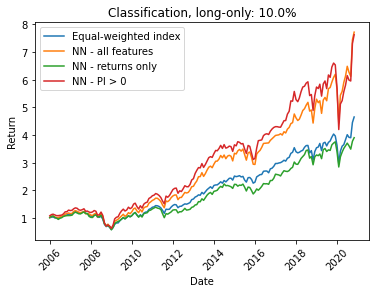

In [40]:
#calculate cost-adjusted returns & plot
#portfolio params defined in 1d
returns_matrix, weight_matrix, rank_table, model_output = get_Matrices(model, x_test, df_test, is_regression = is_regression, pct = pct, is_short = is_short, company_name = df_train.columns[0])
rets_pi, cumrets_pi = calc_returns(returns_matrix, weight_matrix = weight_matrix, k = k)

#calculate return & weight matrix for base strat - i.e. long 100%
returns_matrix_equal, weight_matrix_equal, rank_table_equal, model_output = get_Matrices(model, x_test, df_test,is_regression = is_regression, pct = 1, is_short = False, company_name = df_train.columns[0])
rets_equal, cumrets_equal = calc_returns(returns_matrix_equal, weight_matrix = weight_matrix_equal, k = k)

plt.plot(cumrets_equal.index, cumrets_equal, label = "Equal-weighted index")
plt.plot(cumrets.index, cumrets, label = "NN - all features")
plt.plot(cumrets_retonly.index, cumrets_retonly, label = "NN - returns only")
plt.plot(cumrets_pi.index, cumrets_pi, label = "NN - PI > 0")
plt.legend();
plt.xlabel("Date");
plt.xticks(rotation = 45);
plt.ylabel("Return")
if is_regression:
    title = "Regression"
else:
    title = "Classification"
if is_short:
    title = title + ", long-short: " + str(pct*100) + "%"
else:
    title = title + ", long-only: " + str(pct*100) + "%"
plt.title(title);

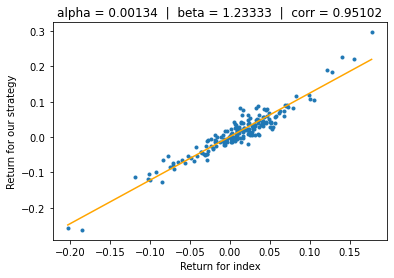

In [41]:
regression_analysis(np.array(rets_equal),np.array(rets_pi))

In [42]:
#sharpe ratio
print("NN sharpe, all features: ", sharpe)
print("NN sharpe, returns only: ", sharpe_retonly)

sharpe_pi = calc_sharpe(rets_pi)
print("NN sharpe, PI > 0: ", sharpe_pi)
print("Base index sharpe: ", sharpe_equal)

NN sharpe, all features:  0.6764465416111847
NN sharpe, returns only:  0.5061514755807156
NN sharpe, PI > 0:  0.6358804933903608
Base index sharpe:  0.6120306030872815


In [43]:
#permutation importance
#importance = feature_importance(model, x_test, y_test, features, n_repeats=5, random_state=seed, is_regression = is_regression)

In [44]:
# save model
if is_regression == True:
    label = "Models/NNreg_" + str(len(features)) + "features_" + str(len(hidden)) + "layers_" + str(num_epochs) + "epochs.h5"
else:
    label = "Models/NNclf_" + str(len(features)) + "features_" + str(len(hidden)) + "layers_" + str(num_epochs) + "epochs.h5"

model.save(label)
print("Model saved to: " + label)
#loaded_model = tf.keras.models.load_model(label, compile = False)

Model saved to: Models/NNclf_23features_5layers_10epochs.h5


# 3) MLP regression

In [40]:
#model params
hidden = [300,300,150,150,50]
dropout = [0.5,0.5,0.3,0.3,0.1]
is_regression = True
learning_rate = 0.001
num_epochs = 10

## 3a) All features

Training Set: 21742, Test Set: 71315 



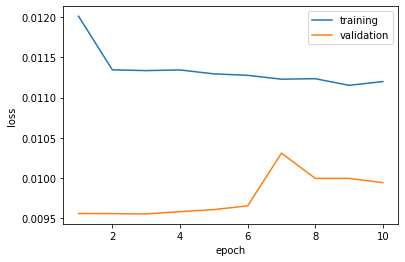

In [41]:
#model params defined in 1d
#reset seed
tf.random.set_seed(seed)

#split data
features = ["debt_assets", "de_ratio", "evm", "pe_exi",
               "roe", "npm","ps", "ptb", "pcf", "aftret_invcapx",
              "CPI", "PMI", "PPI", "FedFundsTargetRate", "GDP", 
              "MedianHomeSalesPrice", "PrivateHousingStarts","NonFarmPayrolls", "Unemployment",
            "MEDPTG", "PCTUP4W", "PCTDOWN4W", "volume",
             "return_1M", "return_3M", "return_6M", "return_9M", "return_12M"]
target = "pred_target"
x_train, y_train, x_test, y_test = get_TrainTest(df_train,df_test,features, target, is_regression = is_regression)

#create model & train
model = create_NN(hidden, dropout, input_dim = len(features), is_regression = is_regression, std = 0.01, seed = seed)
#print(model.summary())
model, history = train_NN(model, x_train, y_train, x_test, y_test, learning_rate = learning_rate, is_regression = is_regression, num_epochs = num_epochs, plot_graph = True)

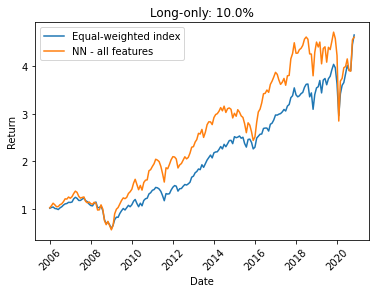

In [42]:
#calculate cost-adjusted returns & plot
#portfolio params defined in 1d

returns_matrix, weight_matrix, rank_table, model_output = get_Matrices(model, x_test, df_test,is_regression = is_regression, pct = pct, is_short = is_short, company_name = df_train.columns[0])
rets, cumrets = calc_returns(returns_matrix, weight_matrix = weight_matrix, k = k)

#calculate return & weight matrix for base strat - i.e. long 100%
returns_matrix_equal, weight_matrix_equal, rank_table_equal, model_output = get_Matrices(model, x_test, df_test,is_regression = is_regression, pct = 1, is_short = False, company_name = df_train.columns[0])
rets_equal, cumrets_equal = calc_returns(returns_matrix_equal, weight_matrix = weight_matrix_equal, k = k)

plt.plot(cumrets_equal.index, cumrets_equal, label = "Equal-weighted index")
plt.plot(cumrets.index, cumrets, label = "NN - all features")
plt.legend();
plt.xlabel("Date");
plt.xticks(rotation = 45);
plt.ylabel("Return")
plt.title("Long-only: " + str(pct*100) + "%");

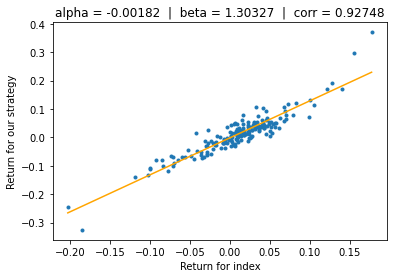

In [50]:
regression_analysis(np.array(rets_equal),np.array(rets))

In [51]:
#sharpe ratio
sharpe = calc_sharpe(rets)
print("NN sharpe: ", sharpe)

sharpe_equal = calc_sharpe(rets_equal)
print("Base index sharpe: ", sharpe_equal)

NN sharpe:  0.4339962888692266
Base index sharpe:  0.6140039709585896


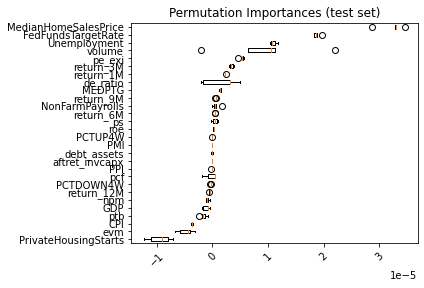

Permutation importance > 0:
['de_ratio', 'pe_exi', 'roe', 'ps', 'FedFundsTargetRate', 'MedianHomeSalesPrice', 'NonFarmPayrolls', 'Unemployment', 'MEDPTG', 'PCTUP4W', 'volume', 'return_1M', 'return_3M', 'return_6M', 'return_9M']


In [52]:
#permutation importance
importance,features_pi = feature_importance(model, x_test, y_test, features, n_repeats=5, random_state=seed, is_regression = is_regression)

In [53]:
# save model
if is_regression == True:
    label = "Models/NNreg_" + str(len(features)) + "features_" + str(len(hidden)) + "layers_" + str(num_epochs) + "epochs.h5"
else:
    label = "Models/NNclf_" + str(len(features)) + "features_" + str(len(hidden)) + "layers_" + str(num_epochs) + "epochs.h5"

model.save(label)
print("Model saved to: " + label)
#loaded_model = tf.keras.models.load_model(label, compile = False)

Model saved to: Models/NNreg_28features_5layers_10epochs.h5


## 3b) Returns-only features

Training Set: 21742, Test Set: 71315 



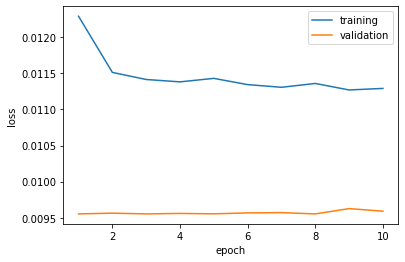

In [54]:
#model params defined in 1d
#reset seed
tf.random.set_seed(seed)

#split data
features = ["return_1M", "return_3M", "return_6M", "return_9M", "return_12M"]
target = "pred_target"
x_train, y_train, x_test, y_test = get_TrainTest(df_train,df_test,features, target, is_regression = is_regression)

#create model & train
model = create_NN(hidden, dropout, input_dim = len(features), is_regression = is_regression, std = 0.01, seed = seed)
#print(model.summary())
model, history = train_NN(model, x_train, y_train, x_test, y_test, learning_rate = learning_rate, is_regression = is_regression, num_epochs = num_epochs, plot_graph = True)

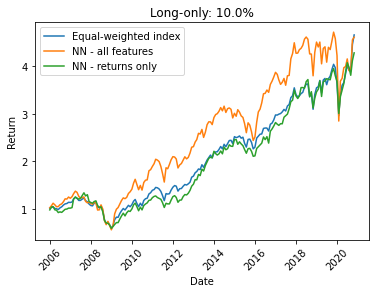

In [55]:
#calculate cost-adjusted returns & plot
#portfolio params defined in 1d
returns_matrix, weight_matrix, rank_table, model_output = get_Matrices(model, x_test, df_test, is_regression = is_regression, pct = pct, is_short = is_short, company_name = df_train.columns[0])
rets_retonly, cumrets_retonly = calc_returns(returns_matrix, weight_matrix = weight_matrix, k = k)

#calculate return & weight matrix for base strat - i.e. long 100%
returns_matrix_equal, weight_matrix_equal, rank_table_equal, model_output = get_Matrices(model, x_test, df_test,is_regression = is_regression, pct = 1, is_short = False, company_name = df_train.columns[0])
rets_equal, cumrets_equal = calc_returns(returns_matrix_equal, weight_matrix = weight_matrix_equal, k = k)

plt.plot(cumrets_equal.index, cumrets_equal, label = "Equal-weighted index")
plt.plot(cumrets.index, cumrets, label = "NN - all features")
plt.plot(cumrets_retonly.index, cumrets_retonly, label = "NN - returns only")
plt.legend();
plt.xlabel("Date");
plt.xticks(rotation = 45);
plt.ylabel("Return")
plt.title("Long-only: " + str(pct*100) + "%");

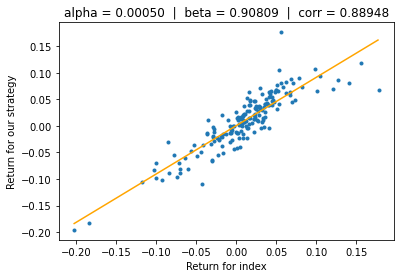

In [56]:
regression_analysis(np.array(rets_equal),np.array(rets_retonly))

In [57]:
#sharpe ratio
print("NN sharpe, all features: ", sharpe)

sharpe_retonly = calc_sharpe(rets_retonly)
print("NN sharpe, returns only: ", sharpe_retonly)
print("Base index sharpe: ", sharpe_equal)

NN sharpe, all features:  0.4339962888692266
NN sharpe, returns only:  0.5668546300817876
Base index sharpe:  0.6140039709585896


In [58]:
#permutation importance
#importance = feature_importance(model, x_test, y_test, features, n_repeats=5, random_state=seed, is_regression = is_regression)

In [59]:
# save model
if is_regression == True:
    label = "Models/NNreg_" + str(len(features)) + "features_" + str(len(hidden)) + "layers_" + str(num_epochs) + "epochs.h5"
else:
    label = "Models/NNclf_" + str(len(features)) + "features_" + str(len(hidden)) + "layers_" + str(num_epochs) + "epochs.h5"

model.save(label)
print("Model saved to: " + label)
#loaded_model = tf.keras.models.load_model(label, compile = False)

Model saved to: Models/NNreg_5features_5layers_10epochs.h5


## 3c) Permutation Importance Features
- Only those with PI above 0
- and return features!

['PCTUP4W', 'FedFundsTargetRate', 'NonFarmPayrolls', 'return_9M', 'return_3M', 'Unemployment', 'volume', 'ps', 'de_ratio', 'MEDPTG', 'return_12M', 'return_1M', 'pe_exi', 'MedianHomeSalesPrice', 'roe', 'return_6M', 'PCTDOWN4W']
Training Set: 21742, Test Set: 71315 



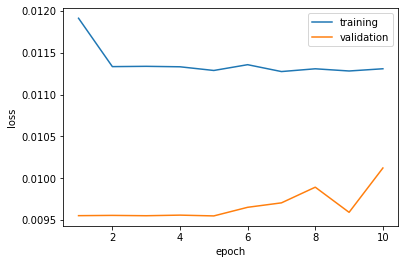

In [60]:
#model params defined in 1d
#reset seed
tf.random.set_seed(seed)

#split data
features = ['npm', 'aftret_invcapx', 'PMI', 'FedFundsTargetRate', 'GDP', 
            'PrivateHousingStarts', 'NonFarmPayrolls', 'Unemployment', 
            'MEDPTG', 'PCTDOWN4W', 'return_1M', 'return_9M', 'return_12M']
features = ListUnion(features_pi,['MEDPTG', 'PCTDOWN4W', 'return_1M', 'return_9M', 'return_12M'])
print(features)
target = "pred_target"
x_train, y_train, x_test, y_test = get_TrainTest(df_train,df_test,features, target, is_regression = is_regression)

#create model & train
model = create_NN(hidden, dropout, input_dim = len(features), is_regression = is_regression, std = 0.01, seed = seed)
#print(model.summary())
model, history = train_NN(model, x_train, y_train, x_test, y_test, learning_rate = learning_rate, is_regression = is_regression, num_epochs = num_epochs, plot_graph = True)

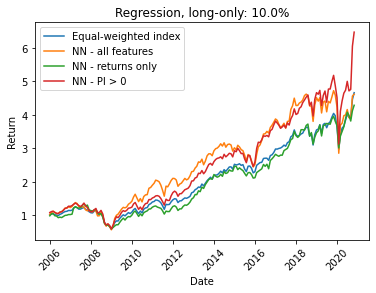

In [61]:
#calculate cost-adjusted returns & plot
#portfolio params defined in 1d
returns_matrix, weight_matrix, rank_table, model_output = get_Matrices(model, x_test, df_test, is_regression = is_regression, pct = pct, is_short = is_short, company_name = df_train.columns[0])
rets_pi, cumrets_pi = calc_returns(returns_matrix, weight_matrix = weight_matrix, k = k)

#calculate return & weight matrix for base strat - i.e. long 100%
returns_matrix_equal, weight_matrix_equal, rank_table_equal, model_output = get_Matrices(model, x_test, df_test,is_regression = is_regression, pct = 1, is_short = False, company_name = df_train.columns[0])
rets_equal, cumrets_equal = calc_returns(returns_matrix_equal, weight_matrix = weight_matrix_equal, k = k)

plt.plot(cumrets_equal.index, cumrets_equal, label = "Equal-weighted index")
plt.plot(cumrets.index, cumrets, label = "NN - all features")
plt.plot(cumrets_retonly.index, cumrets_retonly, label = "NN - returns only")
plt.plot(cumrets_pi.index, cumrets_pi, label = "NN - PI > 0")
plt.legend();
plt.xlabel("Date");
plt.xticks(rotation = 45);
plt.ylabel("Return")
if is_regression:
    title = "Regression"
else:
    title = "Classification"
if is_short:
    title = title + ", long-short: " + str(pct*100) + "%"
else:
    title = title + ", long-only: " + str(pct*100) + "%"
plt.title(title);

In [62]:
#save rankings
model_output = model.predict(x_test)
if is_regression == False:
    model_output = model_output[:,1]
#map to original test dataframe for price data
predictions = df_test.iloc[:,:5]
predictions["pred"] = model_output

#rank predictions
predictions["rank"] = predictions.groupby("month")["pred"].rank("dense", ascending = False)
pred_table = pd.pivot_table(predictions, values="pred", index=["month"],
                columns=[df_test.columns[0]])
rank_table = pd.pivot_table(predictions, values="rank", index=["month"],
                columns=[df_test.columns[0]])

rank_table.to_csv("Rankings/NN_Regression_ranks.csv")
pred_table.to_csv("Rankings/NN_Regression_modeloutputs.csv")

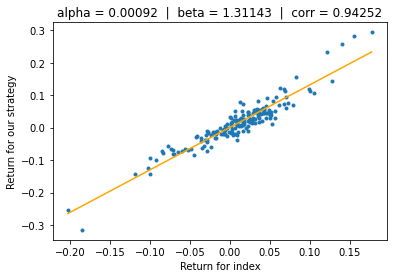

In [60]:
regression_analysis(np.array(rets_equal),np.array(rets_pi))

In [61]:
#sharpe ratio
print("NN sharpe, all features: ", sharpe)
print("NN sharpe, returns only: ", sharpe_retonly)

sharpe_pi = calc_sharpe(rets_pi)
print("NN sharpe, PI > 0: ", sharpe_pi)
print("Base index sharpe: ", sharpe_equal)

NN sharpe, all features:  0.4339962888692266
NN sharpe, returns only:  0.5668546300817876
NN sharpe, PI > 0:  0.5939908144809816
Base index sharpe:  0.6140039709585896


In [62]:
#permutation importance
#importance = feature_importance(model, x_test, y_test, features, n_repeats=5, random_state=seed, is_regression = is_regression)

In [63]:
# save model
if is_regression == True:
    label = "Models/NNreg_" + str(len(features)) + "features_" + str(len(hidden)) + "layers_" + str(num_epochs) + "epochs.h5"
else:
    label = "Models/NNclf_" + str(len(features)) + "features_" + str(len(hidden)) + "layers_" + str(num_epochs) + "epochs.h5"

model.save(label)
print("Model saved to: " + label)
#loaded_model = tf.keras.models.load_model(label, compile = False)

Model saved to: Models/NNreg_17features_5layers_10epochs.h5


# 4) Pairwise LTR - RankNet
- queries = dates
- documents = valid tickers, the features of which are xi
- scores = future 1M returns, si

Target probabilities:

- Pij = 1 if si > sj, 0.5 if si = sj, 0 if si < sj

Predicted probabilities
- Oij = f(xi) - f(xj)
- Squeeze through logistic function
- Qij = 1-Qji = exp(Oij) / (1 + exp(Oij)

Use cross-entropy loss.

In [19]:
#model params
hidden = [300,300,150,150,50]
dropout = [0.5,0.5,0.3,0.3,0.1]
is_regression = True
is_ltr = True
learning_rate = 0.001
num_epochs = 10
seed = 1

## 4a) Build model

In [73]:
# model architecture
class RankNet(Model):
    def __init__(self):
        super().__init__()
        #input + hidden layers
        stddev = 0.01
        seed = 1
        self.dense = [layers.Dense(100, activation='relu',kernel_initializer=initializers.RandomNormal(stddev=stddev, seed = seed)), 
                      layers.Dense(100, activation='relu',kernel_initializer=initializers.RandomNormal(stddev=stddev, seed = seed))]
        self.dropout = [Dropout(0.2, seed = seed), 
                      Dropout(0.2, seed = seed)]
        #output layer
        self.o = layers.Dense(1, activation='linear')
        #subtract outputs
        self.oi_minus_oj = layers.Subtract()
    
    def call(self, inputs):
        xi, xj = inputs
        #input layer
        densei = self.dense[0](xi)
        densej = self.dense[0](xj)
        #hidden layers
        for dense, dropout in zip(self.dense[1:],self.dropout[1:]):
            densei = dense(densei)
            densej = dense(densej)
            #dropout
            densei = dropout(densei)
            densej = dropout(densej)
        #output layer
        oi = self.o(densei)
        oj= self.o(densej)
        #subtraction layer
        oij = self.oi_minus_oj([oi, oj])
        #apply sigmoid to output
        output = layers.Activation('sigmoid')(oij)
        return output
    
    def build_graph(self):
        x = [Input(shape=(5)), Input(shape=(5))]
        return Model(inputs=x, outputs=self.call(x))


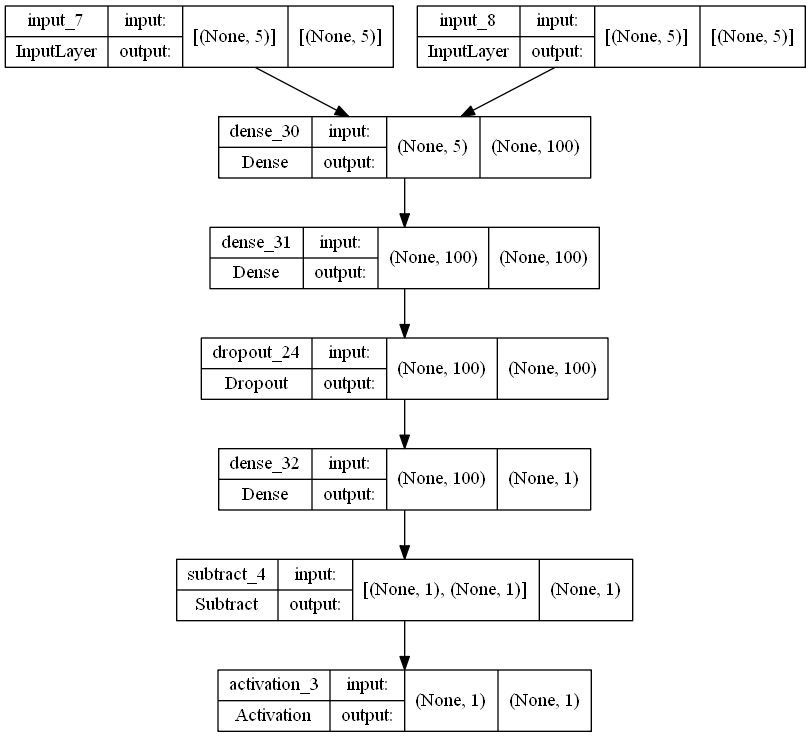

In [74]:
# visualize model architecture
plot_model(RankNet().build_graph(), show_shapes=True)

## 4b) Process data
- We need to create pairs of inputs 
  - 2 each of x_train, x_test; 
  - 1 each of y_train, y_test; 
  - 1 each of pair_id_train, pair_id_test to match pairs of inputs
  
- need more efficient method for creating the pairs.
    - separate validation set by query id
    from sklearn.model_selection import GroupShuffleSplit
    gss = GroupShuffleSplit(test_size=.40, n_splits=1, random_state = 7).split(df, groups=df['id'])
    https://medium.com/predictly-on-tech/learning-to-rank-using-xgboost-83de0166229d

- need to edit this so pair_query_id contains the stock identifier

In [75]:
#model params defined in 1d
#reset seed
tf.random.set_seed(seed)


#split data
features = ["debt_assets", "de_ratio", "evm", "pe_exi",
               "roe", "npm","ps", "ptb", "pcf", "aftret_invcapx",
              "CPI", "PMI", "PPI", "FedFundsTargetRate", "GDP", 
              "MedianHomeSalesPrice", "PrivateHousingStarts","NonFarmPayrolls", "Unemployment",
            "MEDPTG", "PCTUP4W", "PCTDOWN4W", "volume",
             "return_1M", "return_3M", "return_6M", "return_9M", "return_12M"]
target = "pred_target"
x_train, y_train,q_train,x_test,y_test,q_test= get_TrainTest(df_train,df_test,features, target, is_regression = is_regression, is_ltr = is_ltr)


Training Set: 21742, Test Set: 71315 



In [76]:
#format train set
"""
tic = time()
xi_train, xj_train, pij_train, pair_train, query_train = create_pairs(
                query = q_train, doc_features = x_train, doc_scores = y_train)
toc = time()
print("training set:", toc - tic, "secs")
print(np.shape(xi_train))

np.save("PairwiseLTR/xi_train.npy",xi_train)
np.save("PairwiseLTR/xj_train.npy",xj_train)
np.save("PairwiseLTR/pij_train.npy",pij_train)
np.save("PairwiseLTR/pair_train.npy",pair_train)
np.save("PairwiseLTR/query_train.npy",query_train)
print("done")
"""

'\ntic = time()\nxi_train, xj_train, pij_train, pair_train, query_train = create_pairs(\n                query = q_train, doc_features = x_train, doc_scores = y_train)\ntoc = time()\nprint("training set:", toc - tic, "secs")\nprint(np.shape(xi_train))\n\nnp.save("PairwiseLTR/xi_train.npy",xi_train)\nnp.save("PairwiseLTR/xj_train.npy",xj_train)\nnp.save("PairwiseLTR/pij_train.npy",pij_train)\nnp.save("PairwiseLTR/pair_train.npy",pair_train)\nnp.save("PairwiseLTR/query_train.npy",query_train)\nprint("done")\n'

In [77]:
#format test set
"""
tic = time()   
xi_test, xj_test, pij_test, pair_test, query_test = create_pairs(
                query = q_test, doc_features = x_test, doc_scores = y_test)
toc = time()
print("training set:", toc - tic, "secs")
print(np.shape(xi_test))

np.save("PairwiseLTR/xi_test.npy",xi_test)
np.save("PairwiseLTR/xj_test.npy",xj_test)
np.save("PairwiseLTR/pij_test.npy",pij_test)
np.save("PairwiseLTR/pair_test.npy",pair_test)
np.save("PairwiseLTR/query_test.npy",query_test)
print("done")
"""

'\ntic = time()   \nxi_test, xj_test, pij_test, pair_test, query_test = create_pairs(\n                query = q_test, doc_features = x_test, doc_scores = y_test)\ntoc = time()\nprint("training set:", toc - tic, "secs")\nprint(np.shape(xi_test))\n\nnp.save("PairwiseLTR/xi_test.npy",xi_test)\nnp.save("PairwiseLTR/xj_test.npy",xj_test)\nnp.save("PairwiseLTR/pij_test.npy",pij_test)\nnp.save("PairwiseLTR/pair_test.npy",pair_test)\nnp.save("PairwiseLTR/query_test.npy",query_test)\nprint("done")\n'

In [78]:
#load training set
xi_train= np.load("PairwiseLTR/xi_train.npy")
xj_train= np.load("PairwiseLTR/xj_train.npy")
pij_train = np.load("PairwiseLTR/pij_train.npy")
pair_train = np.load("PairwiseLTR/pair_train.npy")
query_train = np.load("PairwiseLTR/query_train.npy", allow_pickle = True)

#load test set
xi_test= np.load("PairwiseLTR/xi_test.npy")
xj_test= np.load("PairwiseLTR/xj_test.npy")
pij_test = np.load("PairwiseLTR/pij_test.npy")
pair_test = np.load("PairwiseLTR/pair_test.npy")
query_test = np.load("PairwiseLTR/query_test.npy", allow_pickle = True)

print("done")

done


## 4c) Train RankNet

In [ ]:
# train model using compile and fit
learning_rate = 1e-6
ranknet = RankNet()
opt = optimizers.Adam(learning_rate=learning_rate)
ranknet.compile(optimizer=opt, loss='binary_crossentropy')

history = ranknet.fit([xi_train, xj_train], pij_train, epochs=5, batch_size=500, validation_data=([xi_test, xj_test], pij_test))

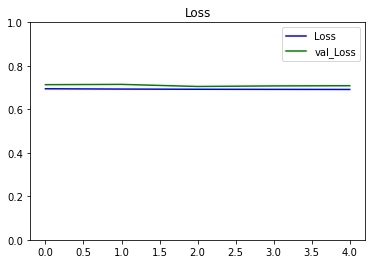

In [28]:
# function for plotting loss
def plot_metrics(train_metric, val_metric=None, metric_name=None, title=None, ylim=5):
    plt.title(title)
    plt.ylim(0,ylim)
    plt.plot(train_metric,color='blue',label=metric_name)
    if val_metric is not None: plt.plot(val_metric,color='green',label='val_' + metric_name)
    plt.legend(loc="upper right")

# plot loss history
plot_metrics(history.history['loss'], history.history['val_loss'], "Loss", "Loss", ylim=1.0)

In [352]:
# save model
if is_regression == True:
    label = "Models/NNreg_" + str(len(features)) + "features_" + str(len(hidden)) + "layers_" + str(num_epochs) + "epochs.h5"
if is_ltr == True:
    label = "Models/PairwiseLTR.tf"
else:
    label = "Models/NNclf_" + str(len(features)) + "features_" + str(len(hidden)) + "layers_" + str(num_epochs) + "epochs.h5"

ranknet.save(label)
print("Model saved to: " + label)
#loaded_model = tf.keras.models.load_model(label, compile = False)

INFO:tensorflow:Assets written to: Models/PairwiseLTR.tf\assets
Model saved to: Models/PairwiseLTR.tf


## 4d) Evaluate strategy
Two methods to convert pairs into rankings
- Bradley Terry and Elo models: convert sign(pred-0.5) into {-1, 1}
- simply sum all predictions {0 to 1} for each stock in a given month ==> current approach

In [ ]:
#make predictions
tic = time()
#n_outputs = 1000000
n_outputs = len(xi_test)
print(n_outputs)
model_output = ranknet.predict([xi_test[:n_outputs], xj_test[:n_outputs]])
toc = time()
print("make predictions:", toc - tic, "secs")

14177648
make predictions: 197.7856822013855 secs


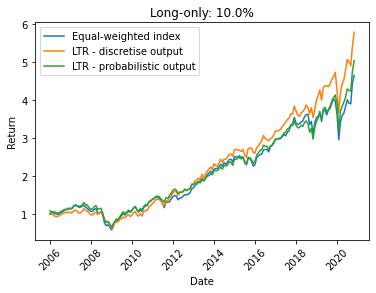

In [ ]:
#calc returns
k = 3
pct = 0.1
is_short = False
discretise = False
returns_matrix1, weight_matrix1, rank_table1, _1 = get_Matrices_LTR(
                    model_output, df_test, company_name = "TICKER", pct = pct, is_short = is_short, max_ret = 10, discretise = True)
returns_matrix2, weight_matrix2, rank_table2, _2 = get_Matrices_LTR(
                    model_output, df_test, company_name = "TICKER", pct = pct, is_short = is_short, max_ret = 10, discretise = False)
rets1, cumrets1 = calc_returns(returns_matrix1, weight_matrix = weight_matrix1, k = k)
rets2, cumrets2 = calc_returns(returns_matrix2, weight_matrix = weight_matrix2, k = k)

#calculate return & weight matrix for base strat - i.e. long 100%

plt.plot(cumrets_equal.index, cumrets_equal, label = "Equal-weighted index")
plt.plot(cumrets1.index, cumrets1, label = "LTR - discretise output")
plt.plot(cumrets2.index, cumrets2, label = "LTR - probabilistic output")
plt.legend();
plt.xlabel("Date");
plt.xticks(rotation = 45);
plt.ylabel("Return")
plt.title("Long-only: " + str(pct*100) + "%");

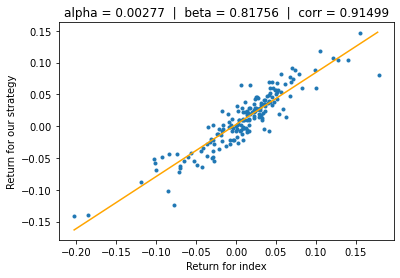

In [ ]:
regression_analysis(np.array(rets_equal),np.array(rets1))

In [ ]:
#sharpe ratio
sharpe = calc_sharpe(rets1)
print("LTR discretised sharpe: ", sharpe)
mdd = calc_mdd(rets1)
print("LTR discretised mdd: ", mdd[0])

sharpe = calc_sharpe(rets2)
print("LTR probabilistic sharpe: ", sharpe)
mdd = calc_mdd(rets2)
print("LTR probabilistic mdd: ", mdd[0])

sharpe_equal = calc_sharpe(rets_equal)
print("Base index sharpe: ", sharpe_equal)
mdd_equal = calc_mdd(rets_equal)
print("Base index mdd: ", mdd_equal[0])

LTR discretised sharpe:  0.7885419089326925
LTR discretised mdd:  0.44301675293513954
LTR probabilistic sharpe:  0.7171945398228148
LTR probabilistic mdd:  0.49454656226401617
Base index sharpe:  0.6120306030872815
Base index mdd:  0.5304379670749022


## 4e) Train RankNet with NDCG

In [96]:
# train model using compile and fit
learning_rate = 1e-2
ranknet = RankNet()
opt = optimizers.Adam(learning_rate=learning_rate)
ranknet.compile(optimizer=opt, loss='binary_crossentropy',
    metrics=tfr.keras.metrics.get("ndcg", topn=5, name="NDCG@5"))

history = ranknet.fit([xi_train, xj_train], pij_train, epochs=5, batch_size=500, validation_data=([xi_test, xj_test], pij_test))

Epoch 1/5
7863/7863 [==============================] - 49s 6ms/step - loss: 0.6795 - NDCG@5: 0.5028 - val_loss: 0.7602 - val_NDCG@5: 0.5017
Epoch 2/5
7863/7863 [==============================] - 50s 6ms/step - loss: 0.6622 - NDCG@5: 0.5028 - val_loss: 0.7959 - val_NDCG@5: 0.5017
Epoch 3/5
7863/7863 [==============================] - 48s 6ms/step - loss: 0.6538 - NDCG@5: 0.5028 - val_loss: 0.8239 - val_NDCG@5: 0.5017
Epoch 4/5
7863/7863 [==============================] - 47s 6ms/step - loss: 0.6489 - NDCG@5: 0.5028 - val_loss: 0.8089 - val_NDCG@5: 0.5017
Epoch 5/5
7863/7863 [==============================] - 47s 6ms/step - loss: 0.6460 - NDCG@5: 0.5028 - val_loss: 0.8216 - val_NDCG@5: 0.5017


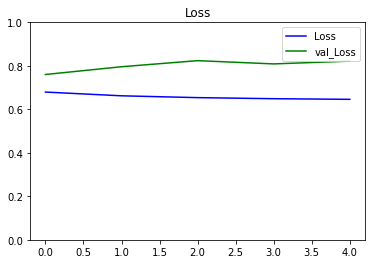

In [97]:
# function for plotting loss
def plot_metrics(train_metric, val_metric=None, metric_name=None, title=None, ylim=5):
    plt.title(title)
    plt.ylim(0,ylim)
    plt.plot(train_metric,color='blue',label=metric_name)
    if val_metric is not None: plt.plot(val_metric,color='green',label='val_' + metric_name)
    plt.legend(loc="upper right")

# plot loss history
plot_metrics(history.history['loss'], history.history['val_loss'], "Loss", "Loss", ylim=1.0)

In [352]:
# save model
if is_regression == True:
    label = "Models/NNreg_" + str(len(features)) + "features_" + str(len(hidden)) + "layers_" + str(num_epochs) + "epochs.h5"
if is_ltr == True:
    label = "Models/PairwiseLTR_NDCG.tf"
else:
    label = "Models/NNclf_" + str(len(features)) + "features_" + str(len(hidden)) + "layers_" + str(num_epochs) + "epochs.h5"

ranknet.save(label)
print("Model saved to: " + label)
#loaded_model = tf.keras.models.load_model(label, compile = False)

INFO:tensorflow:Assets written to: Models/PairwiseLTR.tf\assets
Model saved to: Models/PairwiseLTR.tf


## 4f) Evaluate strategy
Two methods to convert pairs into rankings
- Bradley Terry and Elo models: convert sign(pred-0.5) into {-1, 1}
- simply sum all predictions {0 to 1} for each stock in a given month ==> current approach

In [98]:
#make predictions
tic = time()
#n_outputs = 1000000
n_outputs = len(xi_test)
print(n_outputs)
model_output = ranknet.predict([xi_test[:n_outputs], xj_test[:n_outputs]])
toc = time()
print("make predictions:", toc - tic, "secs")

14177648
make predictions: 210.3352406024933 secs


C:\Users\pyliu\AppData\Local\Temp/ipykernel_94180/662977103.py:25: RuntimeWarning: divide by zero encountered in true_divide
  weight_matrix[rank_table.lt(np.floor(pct*rank_table.max(axis = 1))+1, axis = 0)] = 1/np.transpose(np.tile(np.floor(rank_table.max(axis = 1)*pct),(len(rank_table.columns),1)))


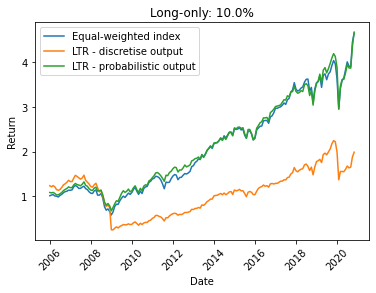

In [99]:
#calc returns
k = 3
pct = 0.1
is_short = False
discretise = False
returns_matrix1, weight_matrix1, rank_table1, _1 = get_Matrices_LTR(
                    model_output, df_test, company_name = "TICKER", pct = pct, is_short = is_short, max_ret = 10, discretise = True)
returns_matrix2, weight_matrix2, rank_table2, _2 = get_Matrices_LTR(
                    model_output, df_test, company_name = "TICKER", pct = pct, is_short = is_short, max_ret = 10, discretise = False)
rets1, cumrets1 = calc_returns(returns_matrix1, weight_matrix = weight_matrix1, k = k)
rets2, cumrets2 = calc_returns(returns_matrix2, weight_matrix = weight_matrix2, k = k)

#calculate return & weight matrix for base strat - i.e. long 100%

plt.plot(cumrets_equal.index, cumrets_equal, label = "Equal-weighted index")
plt.plot(cumrets1.index, cumrets1, label = "LTR - discretise output")
plt.plot(cumrets2.index, cumrets2, label = "LTR - probabilistic output")
plt.legend();
plt.xlabel("Date");
plt.xticks(rotation = 45);
plt.ylabel("Return")
plt.title("Long-only: " + str(pct*100) + "%");

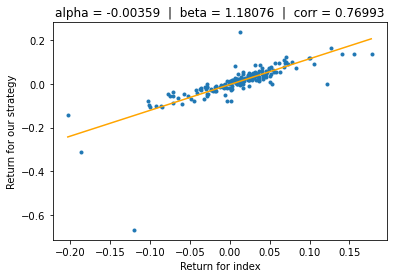

In [100]:
regression_analysis(np.array(rets_equal),np.array(rets1))

In [101]:
#sharpe ratio
sharpe = calc_sharpe(rets1)
print("LTR discretised sharpe: ", sharpe)
mdd = calc_mdd(rets1)
print("LTR discretised mdd: ", mdd[0])

sharpe = calc_sharpe(rets2)
print("LTR probabilistic sharpe: ", sharpe)
mdd = calc_mdd(rets2)
print("LTR probabilistic mdd: ", mdd[0])

sharpe_equal = calc_sharpe(rets_equal)
print("Base index sharpe: ", sharpe_equal)
mdd_equal = calc_mdd(rets_equal)
print("Base index mdd: ", mdd_equal[0])

LTR discretised sharpe:  0.17329528410918518
LTR discretised mdd:  0.8289862085002205
LTR probabilistic sharpe:  0.6343763419437249
LTR probabilistic mdd:  0.4891196628947123
Base index sharpe:  0.6120306030872815
Base index mdd:  0.5304379670749022
